<a href="https://colab.research.google.com/github/emilyj19/TS/blob/master/Deep_Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch

In [0]:
import numpy as np 
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
root_path = 'gdrive/My Drive/FinancialTS/JPmarket_dataset.npz' 
data = np.load(root_path)
data.files

['train_ratios', 'test_ratios', 'train_volumes', 'test_volumes']

In [0]:
train_ratios = data['train_ratios']
test_ratios = data['test_ratios']
train_vols = data['train_volumes']
test_vols = data['test_volumes']

In [0]:
#inputs: data of shape (num_series, num_days, num_bins), num_series = number of time series to use, len_series = length of series,  num_windows = number of series to create from each 
#output: data of shape (num_series, num_windows, len_series*bins)

def create_train_vols_data(data, num_series, len_series, num_windows): 
  total_num_series, num_days, num_bins = data.shape 
  days_series = int(len_series/num_bins)
  
  train_data = np.zeros((num_series, num_windows, len_series))
  
  for i in range(num_series): 
    series_i = data[i]
    norm_series_i = series_i/np.amax(series_i) #normalise series
    for j in range(num_windows):
      start_index = np.random.randint(0,num_days-days_series)
      train_data[i,j] = norm_series_i[start_index:start_index + days_series].flatten()
 
  return train_data
  

In [0]:
#alternative covariate function 
#inputs - input_data of shape [number of time series, length of each time series], freq of data i.e. number of bins per day, and position of special bins as a vector
#returns - data and covariate vector of shape [number of series, length of series, number of special bins + 2] where covariate_vectors[:,:,0] is the input data, 
#covariate_vectors[:,:,1] is the scaled time of day and covariate_vectors[:,:,2:] is the one hot vector for the special bins
#therefore covariate_vectors[:,:,0] is the data and covariate_vectors[:,:,1:] is the actual covariate vector 

def new_create_covariate_data(input_data, freq, pos_of_special_bins): 
  num_series, len_series = input_data.shape
  days = int(len_series/freq)
  num_special_bins = len(pos_of_special_bins)
  covariate_vectors = np.zeros((num_series, len_series, num_special_bins+2))
  
  for n in range(num_series): 
    for d in range(days): 
      for t in range(freq): 
        x = np.zeros(num_special_bins + 1)
        #x[0] is the scaled time of day 
        x[0] = t/freq
        
        check = t in pos_of_special_bins
        
        if check == True: 
          index = pos_of_special_bins.index(t)
          x[index+1] = 1
          
        covariate_vectors[n, d*freq + t, 0] = input_data[n, d*freq + t]
        covariate_vectors[n, d*freq + t, 1:] = x
        
  return covariate_vectors
        

In [0]:
number_series = 20
number_windows = 100
T = 3*64
special_bins = [0,31,32,63]

In [0]:
training_vol = create_train_vols_data(train_vols, number_series, T, number_windows)
covars_training_data = np.zeros((number_series, number_windows, T, len(special_bins)+2))

for i in range(number_series): 
  covars = new_create_covariate_data(training_vol[i], 64, special_bins)
  covars_training_data[i] = covars
  
  
covars_train_data = torch.FloatTensor(covars_training_data)

In [0]:
test_volume = train_vols[0:number_series].reshape((number_series,-1))

norm_test_vols = np.zeros(test_volume.shape)
for i in range(number_series): 
  norm_test_vols[i] = test_volume[i]/np.amax(train_vols[i])
  
new_test_data = norm_test_vols[:,T:2*T]

covars_test_data = new_create_covariate_data(new_test_data, 64, [0,31,32,63])

covars_test_data = torch.FloatTensor(covars_test_data)

In [0]:
#class for the global model 
#forward pass - input data of shape [num_series, length of each series, length of covariate vector + 1]
#forward pass outputs fixed effects of shape [num_series, len_series]

class GlobalEffects(nn.Module): 
  def __init__(self, input_size, num_factors, hidden_size, batch_size, output_size = 1, num_layers = 1): 
    super().__init__()
    self.input_size = input_size
    self.num_factors = num_factors
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.output_size = output_size
    self.num_layers = num_layers
    
    self.linears = nn.ModuleList([nn.Linear(self.hidden_size, self.output_size, bias = False) for i in range(self.num_factors)])
    self.lstms = nn.ModuleList([nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers) for i in range(self.num_factors)])
    
    self.w = torch.nn.Parameter(torch.zeros(batch_size, num_factors))
    
  def init_hidden(self): 
    hidden = [torch.zeros(self.num_layers, self.batch_size, self.hidden_size) for i in range(self.num_factors)]
    return hidden
    
  def forward(self, input_data, hidden): 
    x = input_data[:,:,1:]
    for i in range(self.num_factors): 
      lstm_out, hidden[i] = self.lstms[i](x.view(x.shape[1], self.batch_size, -1))
      g_i = self.linears[i](lstm_out).view(1, self.batch_size, -1) #shape of g_i = [1, batch_size, seq_len]
      
      if i == 0: 
        g = g_i
      else:
        g = torch.cat((g,g_i), dim=0)

    fixed_effects = torch.zeros((self.batch_size, g.shape[2]))
    
    for i in range(self.batch_size): 
      for j in range(g.shape[2]): 
        fixed_effects[i,j] = torch.dot(self.w[i], g[:,i,j])
      
    return fixed_effects
     
      

In [0]:
#class for the DF-RNN local model 
#parameters to define: input_size = number of elements in covariates vector, num_series = number of time series in the data
#forward pass inputs: fixed effects output from global model, input data of shape [num_series, length of each series, length of covariate vector + 1] and whether or not to assume a gaussian likelihood 
#forward pass outputs total log likelihood for the given data and sigma of shape [num_series, len_series]

class DF_RNN(nn.Module): 
  def __init__(self, input_size, hidden_size, batch_size, num_series, output_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.output_size = output_size
    self.num_series = num_series
    
    self.rnns = nn.ModuleList([nn.RNN(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = 1) for i in range(self.num_series)])
    self.linears = nn.ModuleList([nn.Linear(self.hidden_size, self.output_size) for i in range(self.num_series)])
    
  def init_hidden(self): 
    hidden = [torch.zeros(1, self.batch_size, self.hidden_size) for i in range(self.num_series)]
    return hidden
    
  def forward(self, input_data, hidden, fixed_effects, gaussian_likelihood, prediction): 
    z = input_data[:,:,0]
    x = input_data[:,:,1:]
    
    sigma = torch.zeros((self.num_series, x.shape[1]))
    r = torch.zeros(sigma.shape)
    
    for i in range(self.num_series): 
      data = x[i]
      rnn_out, hidden[i] = self.rnns[i](data.view(data.shape[0], self.batch_size, -1))
      sig = self.linears[i](rnn_out).view(-1)
      
      sigma[i] = torch.abs(sig)
      
      for j in range(sigma.shape[1]):
        r[i,j] = torch.distributions.normal.Normal(0, sigma[i,j]).rsample()
        
    u = fixed_effects + r
        
    if prediction == False: 
    
      if gaussian_likelihood == True: 
        log_lik = self.log_likelihood_Gaussian(z, fixed_effects, sigma)

      else: 
        pass
      
      return log_lik, sigma
    
    else: 
      return sigma
   
  
  def log_likelihood_Gaussian(self, z, f, sigma):
    log_p = torch.zeros(sigma.shape)
    
    for i in range(sigma.shape[0]):
      for j in range(sigma.shape[1]): 
        log_pdf = torch.distributions.normal.Normal(0, sigma[i,j]).log_prob(z[i,j] - f[i,j])    #CHANGED THIS LINE AND NEXT TO HAVE FIXED EFFECTS AS MEAN 
        #scale the likelihood to 0-1
        log_norm_constant = torch.distributions.normal.Normal(0, sigma[i,j]).log_prob(0)
        log_p[i,j] = log_pdf - log_norm_constant
    
    log_lik = torch.sum(log_p)

    return log_lik
  
  
  def log_likelihood_nonGaussian(self, ): #to do 
    pass

In [0]:
learning_rate = 0.01
batch_size = number_series
num_epochs = 1000
hidden_units_global = 50
hidden_units_local = 5
n_factors = 10 
early_stop_patience = 20

In [0]:
global_model = GlobalEffects(input_size = 5, num_factors = n_factors , hidden_size = hidden_units_global, batch_size= number_series)  
local_model = DF_RNN(5, hidden_size = hidden_units_local, batch_size = 1, num_series = number_series, output_size = 1)

In [89]:
## TRAINING ##

optimiser = torch.optim.SGD(list(global_model.parameters()) + list(local_model.parameters()), lr = learning_rate)

train_loss = []
test_loss = []

early_stop_count = 0
 
for t in range(num_epochs): 
  global_model.zero_grad()
  global_hidden = global_model.init_hidden()
  
  local_model.zero_grad()
  local_hidden = local_model.init_hidden()
  
  #data_batch = covars_data
  #print(data_batch.shape)
  
  batch_index = np.random.randint(0,number_windows)
  data_batch = covars_train_data[:,batch_index,:,:].contiguous()
  
  fixed_effects = global_model(data_batch, global_hidden)

  log_lik, sigma = local_model(data_batch, local_hidden, fixed_effects, gaussian_likelihood = True, prediction = False)

  batch_loss = -1*log_lik
    
  optimiser.zero_grad()
  
  batch_loss.backward()

  optimiser.step()
  
  train_loss.append(batch_loss.item())
  
  with torch.no_grad():
    test_data_batch = covars_test_data
    fixed_effects = global_model(test_data_batch, global_hidden)
    
    data = test_data_batch
    log_lik, sigma = local_model(data, local_hidden, fixed_effects, gaussian_likelihood = True, prediction = False)
      
    test_batch_loss = -1*log_lik
      
    test_loss.append(test_batch_loss.item())
    
    if t%100 == 0: 
      print('sigma', sigma)
      print('fixed effects', fixed_effects)
      
  #early stopping
  if test_loss[t] > test_loss[t-1]: 
    early_stop_count += 1
    if early_stop_count == early_stop_patience:
      break
  else: 
    early_stop_count = 0 
  
  print("Epoch: ", t, "loss: ", batch_loss.item(), "test loss: ", test_batch_loss.item())

sigma tensor([[5.1484e-01, 4.1710e-01, 3.6031e-01,  ..., 3.2857e-01, 3.2971e-01,
         4.1782e-01],
        [3.3099e+04, 3.3099e+04, 3.3099e+04,  ..., 3.3099e+04, 3.3099e+04,
         3.3099e+04],
        [4.0815e-01, 4.2150e-01, 4.6111e-01,  ..., 4.1607e-01, 4.1503e-01,
         3.1157e-01],
        ...,
        [2.0368e-01, 4.6534e-02, 4.1005e-02,  ..., 3.4726e-01, 3.5206e-01,
         2.8546e-01],
        [2.7380e-01, 6.0654e-01, 7.2713e-01,  ..., 6.0675e-01, 6.0457e-01,
         6.5303e-01],
        [1.4311e+01, 4.4390e+00, 3.6773e+01,  ..., 1.3181e+01, 3.6773e+01,
         1.3883e+01]])
fixed effects tensor([[1.3729e-03, 1.1467e-03, 1.1472e-03,  ..., 2.4912e-03, 2.4933e-03,
         2.7050e-03],
        [2.3006e+01, 2.1512e+01, 2.1532e+01,  ..., 2.1669e+01, 2.1686e+01,
         2.3283e+01],
        [3.6673e-03, 3.4018e-03, 3.4044e-03,  ..., 3.4302e-03, 3.4326e-03,
         3.7489e-03],
        ...,
        [8.1066e-03, 7.4959e-03, 7.5009e-03,  ..., 7.5264e-03, 7.5307e-03,
     

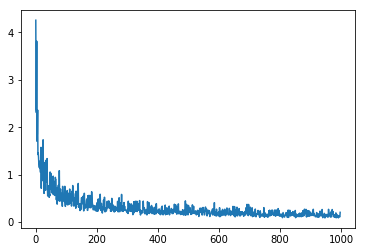

In [90]:
plt.plot(train_loss[2:])

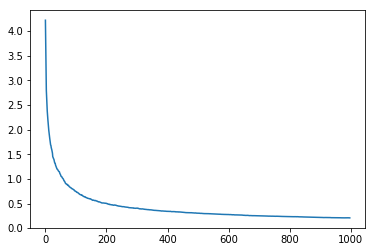

In [91]:
plt.plot(test_loss[2:])

In [0]:
num_paths = 10000
pred_length = 64 

In [0]:
test_vol = test_vols[0:number_series].reshape((number_series,-1))

norm_test_vols = np.zeros(test_vol.shape)
for i in range(number_series): 
  norm_test_vols[i] = test_vol[i]/np.amax(test_vols[i])
  
new_test_data = norm_test_vols[:,:pred_length]

covars_test_data = new_create_covariate_data(new_test_data, 64, [0,31,32,63])

covars_test_data = torch.FloatTensor(covars_test_data)

In [0]:
## PREDICTION ##
paths = np.zeros((number_series, num_paths, pred_length))

with torch.no_grad(): 
  
  test_data = covars_test_data
  
  for n in range(num_paths): 
    
    fixed_effects = global_model(test_data, global_hidden)
    sigma = local_model(test_data, local_hidden, fixed_effects, gaussian_likelihood = True, prediction = True)
    
    for i in range(number_series):
      z = torch.zeros(sigma.shape[1])
      for t in range(sigma.shape[1]): 
        z[t] = torch.distributions.normal.Normal(fixed_effects[i,t], sigma[i,t]).sample() 

      paths[i,n] = z

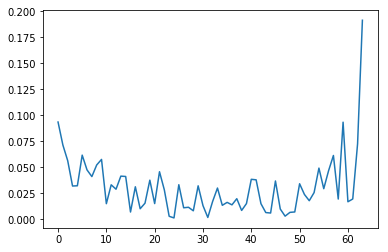

In [110]:
plt.plot(new_test_data[0])
#plt.plot(paths[1,0])

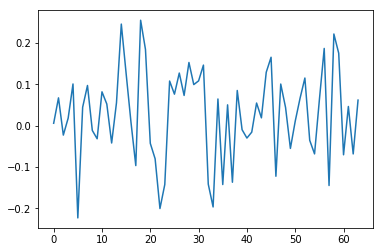

In [117]:
plt.plot(paths[10].mean(0))

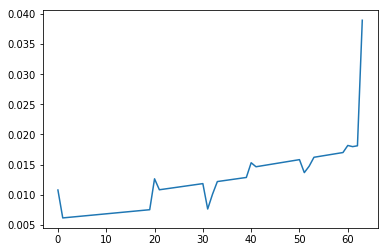

In [125]:
plt.plot(fixed_effects[0].numpy()) #this is sort of the right behaviour but the linear increases seem strange and also this isn't really reflected in the estimates themselves 

In [118]:
paths[0].mean(0)

array([ 0.00049976, -0.03239671, -0.01350039,  0.02024259, -0.00518761,
        0.02420265, -0.0039236 , -0.01430491,  0.02655447,  0.00642082,
       -0.00175647,  0.01571183,  0.00355058,  0.00361022,  0.03944783,
        0.01367937, -0.01481334, -0.02928832,  0.01844477,  0.00973043,
        0.00841626,  0.05258188,  0.01435105,  0.00845323,  0.01671772,
        0.02352473,  0.02934061,  0.00641784, -0.00682119, -0.02509015,
        0.02782221,  0.03079351,  0.01826043,  0.00627361,  0.01708162,
       -0.00394783,  0.02465892,  0.00931524,  0.00884748, -0.00991178,
        0.03348924,  0.01748769,  0.03030849,  0.02427111,  0.02202151,
       -0.01406428,  0.03627779,  0.02799858, -0.00915679,  0.05077866,
       -0.00789345,  0.05023419, -0.00433758,  0.0394172 ,  0.02550632,
        0.00968601, -0.01056902,  0.03379284,  0.02134198,  0.01643704,
        0.02321576,  0.00046401,  0.01103493,  0.04584948])

In [107]:
sigma[0]

tensor([1.7989, 1.8968, 1.9668, 1.9837, 1.9919, 1.9967, 2.0000, 2.0024, 2.0045,
        2.0062, 2.0078, 2.0093, 2.0107, 2.0120, 2.0133, 2.0145, 2.0157, 2.0168,
        2.0179, 2.0189, 2.0198, 2.0208, 2.0216, 2.0225, 2.0232, 2.0240, 2.0247,
        2.0253, 2.0259, 2.0264, 2.0269, 1.9031, 1.9509, 1.9747, 2.0284, 2.0300,
        2.0302, 2.0299, 2.0297, 2.0297, 2.0297, 2.0298, 2.0298, 2.0297, 2.0297,
        2.0295, 2.0294, 2.0292, 2.0290, 2.0287, 2.0284, 2.0281, 2.0277, 2.0273,
        2.0269, 2.0264, 2.0259, 2.0254, 2.0248, 2.0242, 2.0235, 2.0228, 2.0221,
        2.1348])